In [1]:
!pip install chart_studio
!pip install emoji
!pip install Node2Vec
!pip install swifter
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import os
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
from datetime import datetime, date
from collections import Counter
import re
from tqdm.auto import tqdm
import emoji
import string
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from node2vec import Node2Vec
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
import swifter
from plotly import tools
init_notebook_mode(connected=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=a7d3e60326b265c97fa789d96e95f64c197993741bd850b0992bdf16912f1d85
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 7.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=78a7a5d4ce9f81d487e0c54fa0ad8796f8beb291142588ee73495f6980887c19
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for 

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
def get_dataset(country: str, year:str):
  path = f"/content/drive/MyDrive/AI Projects and Dataset/Twitter_Discourse/Super Bowl/{country}/{country}_{year}.csv"
  path_rep = f"/content/drive/MyDrive/AI Projects and Dataset/Twitter_Discourse/Super Bowl/{country}/{country}_{year}_replies.csv"
  df = pd.read_csv(path)
  df_rep = pd.read_csv(path_rep)
  print(df.shape, df_rep.shape)
  return df, df_rep

In [152]:
df_us_2021, df_us_2021_rep = get_dataset("US", "2019")
df_ca_2021, df_ca_2021_rep=get_dataset("CA", "2019")
df_gb_2021, df_gb_2021_rep=get_dataset("GB", "2019")

(24708, 11) (61496, 11)
(3220, 11) (15695, 11)
(3129, 11) (16025, 11)


In [153]:
def extract(start, tweet):
    words = tweet.split()
    return [word[1:] for word in words if word[0] == start]

def strip_punctuation(s):
    return s.translate(str.maketrans('','','!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))

def extract_hashtags(tweet):
    hashtags = [strip_punctuation(tag) for tag in extract('#', tweet)]
    result = []
    for tag in hashtags:
        if tag.lower() not in result:  
            result.append(tag.lower())
    return result

def get_flat_list(plain_list):
    
    flat_list = []
    plain_list = [x for x in plain_list if len(x)>0]
    
    for sublist in tqdm(plain_list):
        for item in sublist:
            flat_list.append(item)
            
    flat_list = [x for x in flat_list if x!='']
    
    return flat_list

In [154]:
df_us_2021['country_code'] = 'US'
df_us_2021['country'] = 'United States'
df_ca_2021['country_code'] = 'CA'
df_ca_2021['country'] = 'Canada'
df_gb_2021['country_code'] = 'GB'
df_gb_2021['country'] = 'Great Britain'
df_us_2021_rep['country_code'] = 'US'
df_ca_2021_rep['country_code'] = 'CA'
df_gb_2021_rep['country_code'] = 'GB'
df_us_2021_rep['country'] = 'United States'
df_ca_2021_rep['country'] = 'Canada'
df_gb_2021_rep['country'] = 'Great Britain'

In [155]:
def fix_dataset(df:pd.DataFrame):
  df['hour'] = pd.to_datetime(df['created_at']).map(lambda x: x.hour)
  df['day'] = pd.to_datetime(df['created_at']).map(lambda x: x.date)
  df['is_reply'] = ~df['in_reply_to_user_id'].isna()
  df['is_quote'] = np.where(df['quote_count']>0, 1, 0)
  df['hashtags'] = df['text'].swifter.apply(extract_hashtags)
  return df

In [156]:
df_us_2021 = fix_dataset(df_us_2021)
df_ca_2021 = fix_dataset(df_ca_2021)
df_gb_2021 = fix_dataset(df_gb_2021)
df_us_2021_rep = fix_dataset(df_us_2021_rep)
df_ca_2021_rep = fix_dataset(df_ca_2021_rep)
df_gb_2021_rep = fix_dataset(df_gb_2021_rep)

Pandas Apply:   0%|          | 0/24708 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3220 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/61496 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15695 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16025 [00:00<?, ?it/s]

In [157]:
def plot_hashtags(df, df_rep, title):
  list_hashtags_us_2021 = get_flat_list(df['hashtags'].tolist())
  c = Counter(list_hashtags_us_2021).most_common(15)
  freq = [i[1] for i in c]
  top_hashtags = [i[0] for i in c]
  plt.figure(figsize=(20, 5))
 
  plt.subplot(1, 2, 1)
  plt.title(title + " Main Tweets")
  plt.bar(top_hashtags[2:], freq[2:])
  plt.xticks(rotation=70)
  plt.subplot(1, 2, 2)
  list_hashtags_us_2021_rep = get_flat_list(df_rep['hashtags'].tolist())
  c = Counter(list_hashtags_us_2021_rep).most_common(15)
  freq_rep = [i[1] for i in c]
  top_hashtags_rep = [i[0] for i in c]
  plt.title(title+" "+ "Replies")
  plt.bar(top_hashtags_rep[2:], freq_rep[2:])
  plt.xticks(rotation=70)
  plt.show()

## Super Bowl Observations with top 15 hashtags
- #ChiefsKingdom (kansas city cheif) was most used hashtags in main tweets for US and Canada while for UK #nfl (National Football League) and #sblv (Super Bowl Live).

  0%|          | 0/10080 [00:00<?, ?it/s]

  0%|          | 0/4790 [00:00<?, ?it/s]

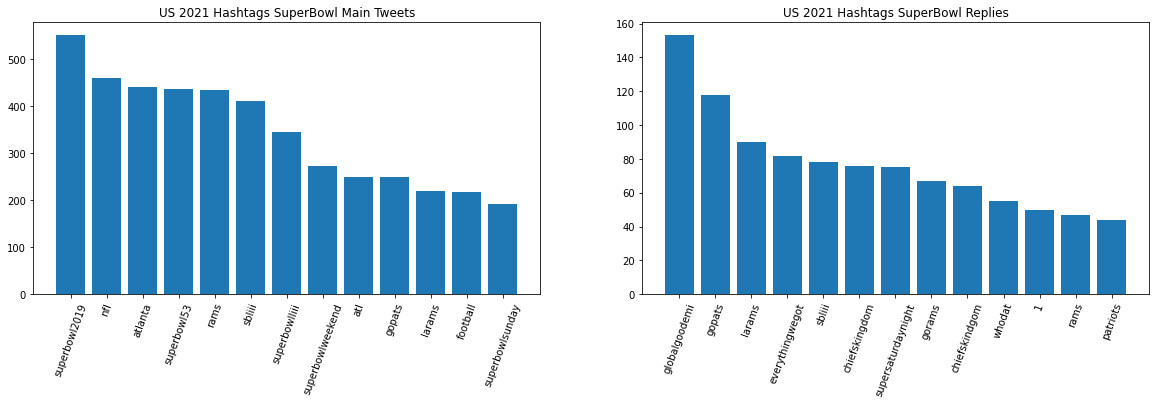

In [158]:
plot_hashtags(df_us_2021, df_us_2021_rep, "US 2021 Hashtags SuperBowl")

  0%|          | 0/1957 [00:00<?, ?it/s]

  0%|          | 0/1432 [00:00<?, ?it/s]

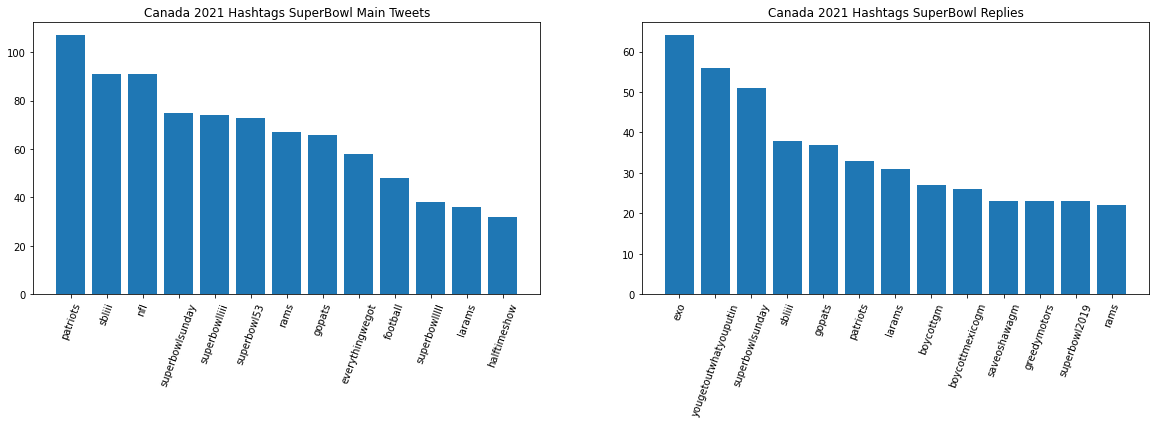

In [159]:
plot_hashtags(df_ca_2021, df_ca_2021_rep, "Canada 2021 Hashtags SuperBowl")

  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/1459 [00:00<?, ?it/s]

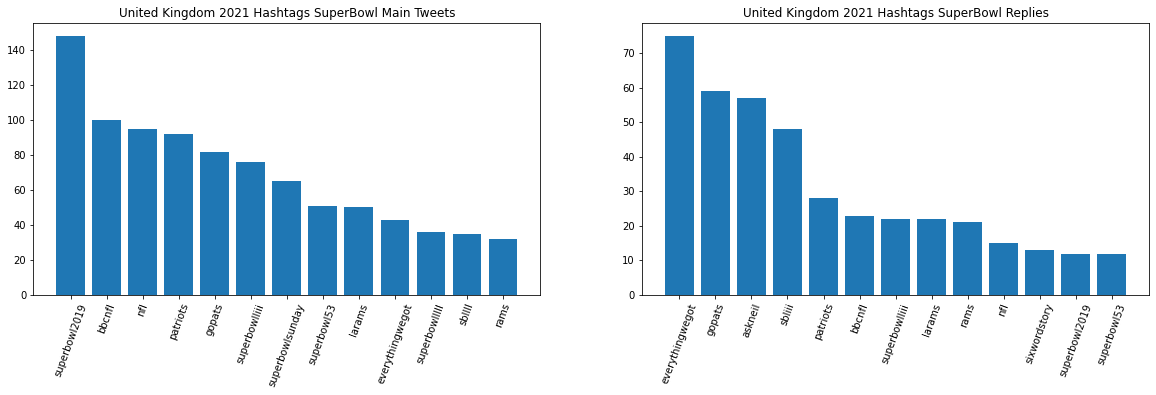

In [160]:
plot_hashtags(df_gb_2021, df_gb_2021_rep, "United Kingdom 2021 Hashtags SuperBowl")

In [161]:
def hashtags_list(df, df_rep):
  list_hashtags_us_2021 = get_flat_list(df['hashtags'].tolist())
  c = Counter(list_hashtags_us_2021).most_common(15)
  freq = [i[1] for i in c]
  top_hashtags = [i[0] for i in c]
  list_hashtags_us_2021_rep = get_flat_list(df_rep['hashtags'].tolist())
  c = Counter(list_hashtags_us_2021_rep).most_common(15)
  freq_rep = [i[1] for i in c]
  top_hashtags_rep = [i[0] for i in c]
  
  return top_hashtags[2:], top_hashtags_rep[2:]

In [168]:
us_main_hash, us_rep_hash_rep = hashtags_list(df_gb_2021, df_gb_2021_rep)

  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/1459 [00:00<?, ?it/s]

In [169]:
us_main_hash

['superbowl2019',
 'bbcnfl',
 'nfl',
 'patriots',
 'gopats',
 'superbowlliii',
 'superbowlsunday',
 'superbowl53',
 'larams',
 'everythingwegot',
 'superbowlllll',
 'sbllll',
 'rams']

In [170]:
us_rep_hash_rep

['everythingwegot',
 'gopats',
 'askneil',
 'sbliii',
 'patriots',
 'bbcnfl',
 'superbowlliii',
 'larams',
 'rams',
 'nfl',
 'sixwordstory',
 'superbowl2019',
 'superbowl53']

In [34]:
def get_hashtag_network(df, hashtag: str):
    ''' returns a dataframe with the edges and timestamp from tweets feed (df)'''
    
    idx = (df.is_reply)  & (df.hashtags.swifter.apply(lambda x: hashtag in x))
    edges_df = df[idx][['author_id','in_reply_to_user_id', 'day']]
    
    edges_df = edges_df.dropna()
    edges_df = edges_df.drop_duplicates().reset_index(drop=True)
    edges_df = edges_df.rename(columns={'author_id': 'from', 'in_reply_to_user_id': 'to'})
    
    return edges_df


def get_strongly_gcc(G):
    """ get the giant strongly connected component of G""" 
    SGcc = max(nx.strongly_connected_components(G), key=len)
    SGcc = G.subgraph(SGcc)
    return SGcc

def get_weakly_gcc(G):
    """ get the giant weakly connected component of G"""  
    WGcc = max(nx.weakly_connected_components(G), key=len)
    WGcc = G.subgraph(WGcc)
    return WGcc
   

def plot_network(G, G_degree=None):
    ''' plot the graph with varying nodesize '''
    
    plt.figure(num=None, figsize=(15, 15), dpi=60, facecolor='w', edgecolor='k')
    pos = nx.spring_layout(G)
    
    if G_degree:
        node_size=[v * 10 for v in dict(G_degree).values()]
    else:
        node_size = 1
        
    nx.draw(G, pos, nodelist=dict(G_degree).keys(), node_size=node_size, width=0.5, alpha=0.5, edge_color='b')
    plt.axis('off')
    plt.show()

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

AttributeError: ignored

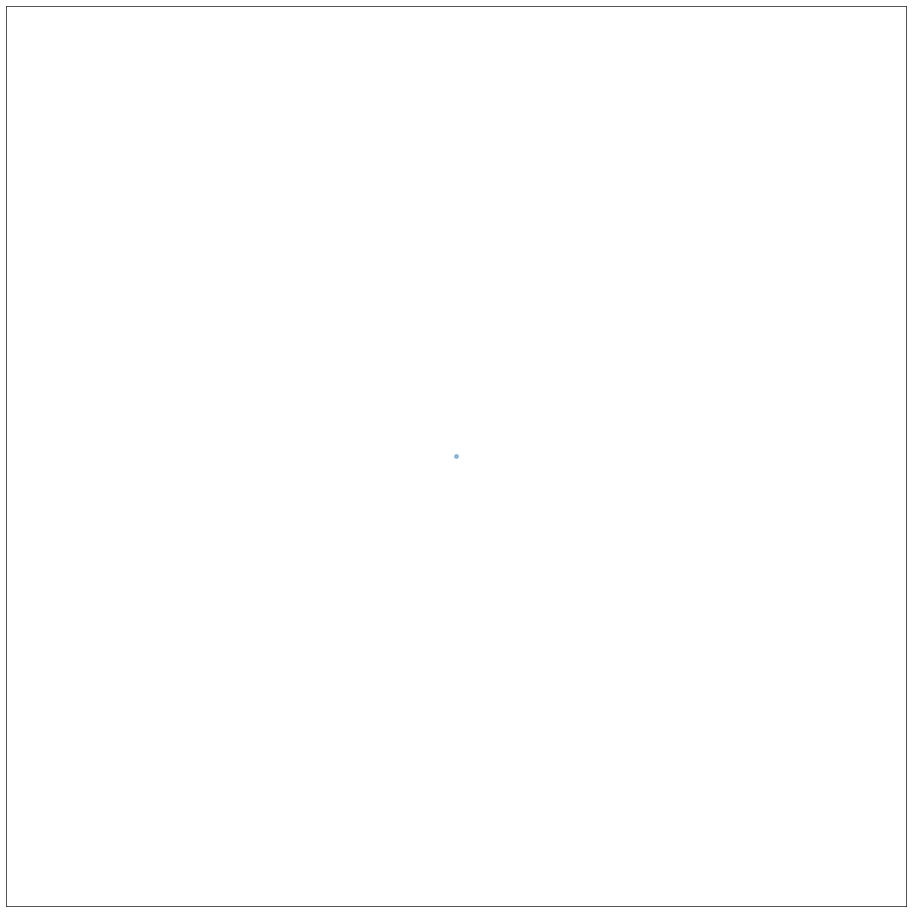

In [45]:
edges_df = get_hashtag_network(df_us_2021, 'superbowl')
G = nx.from_pandas_edgelist(edges_df, 'from', 'to', create_using=nx.DiGraph())
Gcc = get_weakly_gcc(G)
Gcc = Gcc.to_undirected()
Gcc_degree = Gcc.degree()
plot_network(Gcc, Gcc_degree)

In [46]:
edges_df = get_hashtag_network(df_us_2021, 'superbowl')

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

In [47]:
edges_df

,from,to,day
0,408549546,4.085495e+08,2021-02-04
1,57206589,7.670636e+07,2021-02-04
2,75388041,7.538804e+07,2021-02-04
3,78153451,7.420112e+08,2021-02-04
4,3314321224,7.290627e+17,2021-02-04
...,...,...,...
429,828901097196703746,1.017420e+18,2021-02-09
430,175281443,2.254053e+09,2021-02-09
431,65486743,1.108051e+18,2021-02-09
432,777123270,1.108051e+18,2021-02-09


Text(0.5, 0, 'rank')

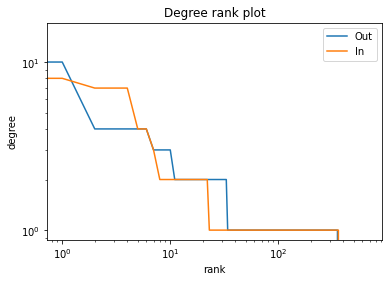

In [48]:
G = nx.from_pandas_edgelist(edges_df, 'from', 'to', create_using=nx.DiGraph())
degrees = G.degree()

out_degrees = G.out_degree()
in_degrees = G.in_degree()
plt.loglog(sorted([n[1] for n in list(out_degrees)], reverse=True))
plt.loglog(sorted([n[1] for n in list(in_degrees)], reverse=True))
plt.title("Degree rank plot")
plt.legend(['Out', 'In'])
plt.ylabel("degree")
plt.xlabel("rank")

In [94]:
hashtag_list = us_main_hash

info = dict()
    
for hashtag in tqdm(hashtag_list):
    
    edges_df = get_hashtag_network(df_us_2021, hashtag)
    days = edges_df.sort_values(by='day')['day'].unique().tolist()
    
    hashtag_info = {}
    
    # initiate an empty graph
    G_day = nx.DiGraph()
    
    for i in range(len(days)):
        
        day_info = {}
        edges = [tuple(x) for x in edges_df[edges_df.day == days[i]][['from', 'to']].drop_duplicates().to_numpy()]
        G_day.update(edges=edges) # updates graphs adding new edges
        G_day_cc = get_weakly_gcc(G_day) # get the giant connected component (for some measures)
        G_day_cc = G_day_cc.to_undirected()
        
        # graph properties
        n = G_day.number_of_nodes()
        e = G_day.number_of_edges()
        de = G_day.degree()
        avgde = np.mean([n[1] for n in list(de)])
        di = nx.diameter(G_day_cc)
        apl = nx.average_shortest_path_length(G_day_cc, weight=None)
        try:
            a = nx.degree_pearson_correlation_coefficient(G_day_cc)
        except:
            a = None
        
        # populates the graph info dict
        day_info['nodes'] = n
        day_info['edges'] = e
        day_info['degrees'] = de
        day_info['avg degrees'] = avgde
        day_info['diameter'] = di
        day_info['avg path lenght'] = apl
        day_info['assortativity'] = a
        
        hashtag_info[days[i]] = day_info
        
    # print('Hashtag: {}, Day : {}, Nodes: {}, Edges: {}'.format(hashtag,
    #                                                            days[i],
    #                                                            day_info['nodes'],
    #                                                            day_info['edges']))
    info[hashtag] = hashtag_info    

  0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16886 [00:00<?, ?it/s]

In [95]:
info_pd_list[5]

,nodes,edges,degrees,avg degrees,diameter,avg path lenght,assortativity
2021-02-04,2,1,"((223921181.0, 1), (1.1340980823527178e+18, 1)...",1.0,1,1.0,NaN
2021-02-06,6,3,"((223921181.0, 1), (1.1340980823527178e+18, 1)...",1.0,1,1.0,NaN
2021-02-07,9,5,"((223921181.0, 1), (1.1340980823527178e+18, 1)...",1.111111,1,1.0,NaN
2021-02-08,11,6,"((223921181.0, 1), (1.1340980823527178e+18, 1)...",1.090909,1,1.0,NaN


In [116]:
info_pd_list = [pd.DataFrame(info[hashtag]).T for hashtag in hashtag_list]

info_pd_list_remp = [x for x in info_pd_list if len(list(x.columns)) > 0]

info_pd_list = info_pd_list_remp

for i in range(len(info_pd_list)):
    try: 
      info_pd_list[i]['edges_created'] = (info_pd_list[i]['edges']-
                                      info_pd_list[i]['edges'].shift(1))/(info_pd_list[i]['nodes']-
                                                                          info_pd_list[i]['nodes'].shift(1))
    except ZeroDivisionError:
      info_pd_list[i]['edges_created'] = (0)


In [117]:
for x in info_pd_list:
  print(list(x.columns))

['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 'edges', 'degrees', 'avg degrees', 'diameter', 'avg path lenght', 'assortativity', 'edges_created']
['nodes', 

IndexError: ignored

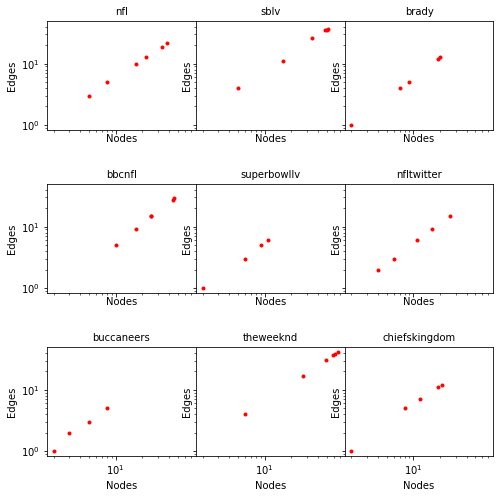

In [119]:
fig, axs = plt.subplots(3,3, figsize=(8, 8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(len(info_pd_list_remp)):

    axs[i].plot(info_pd_list[i]['nodes'], info_pd_list[i]['edges'], '.', c='r')
    axs[i].set_title('{}'.format(hashtag_list[i]), fontsize=10)
    axs[i].set_ylabel('Edges')
    axs[i].set_xlabel('Nodes')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')

fig.suptitle('Edges as a function of Nodes (log scale)', fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

IndexError: ignored

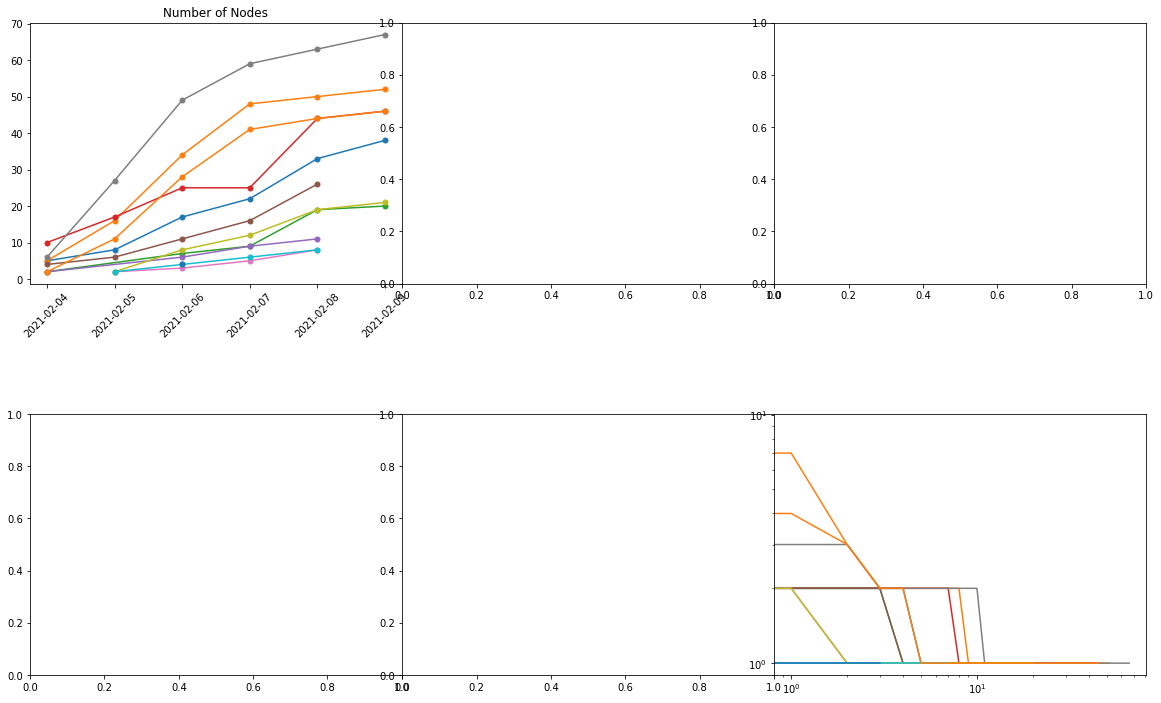

In [121]:
num_colors = len(hashtag_list)
#cm = plt.get_cmap('Accent')

fig, axs = plt.subplots(2,3, figsize=(20, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

params={'markersize':10, 'style':'.-', 'rot':45}

for i in range(len(hashtag_list)):

    params['label'] = hashtag_list[i]
    #params['c'] = cm(1.*i/num_colors)
    info_pd_list[i]['nodes'].plot(ax=axs[0], **params, title='Number of Nodes')
    # info_pd_list[i]['edges_created'].plot(ax=axs[1],  **params, title='Edges Created by New Nodes (Avg)')
    # info_pd_list[i]['diameter'].plot(ax=axs[2], **params, title='Network Diameter (GCC)')
    # info_pd_list[i]['assortativity'].plot(ax=axs[3], **params, title='Assortativity (GCC)')
    # info_pd_list[i]['avg degrees'].plot(ax=axs[4], **params, title='Average Degree')
    axs[5].loglog(sorted([n[1] for n in list(info_pd_list[i]['degrees'][-1])], reverse=True))

axs[0].legend(prop={'size': 14})
axs[5].set_title('Degree rank plot (Day {})'.format(info_pd_list[0].index[-1]))
axs[5].set_ylabel("Degree")
axs[5].set_xlabel("Rank")

for i in range(5):
    axs[i].set_xlim(date(2020, 3, 11), date(2020, 4, 1))
fig.tight_layout()